In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc
plt.style.use('classic')
rc('font', family='serif')
rc('figure', facecolor='w')
from mpl_toolkits.mplot3d import Axes3D
from astropy.io import fits, ascii
from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coord
from collections import OrderedDict
from scipy.interpolate import UnivariateSpline
import os, math
from natsort import natsorted as nsort

import TheCannon
from TheCannon import apogee, dataset, model
import apogee_tools as ap
AP_PATH = os.environ['APOGEE_DATA']

line_list = ap.lines
line_names = line_list.keys()

/home/jess/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [36]:
mann_xm1 = pd.read_csv('/home/jess/Desktop/Research/Mdwarf_project/cannon_runs/raw_data_files/mann_89_APOGEE_x_Gaia.csv')
mann_teff = np.array(mann_xm1['TEFF'])
mann_fe_h = np.array(mann_xm1['FE_H'])
mann_bp_rp = mann_xm1['phot_bp_mean_mag'] - mann_xm1['phot_rp_mean_mag']
mann_g_abs = mann_xm1['phot_g_mean_mag'] + 5*np.log10(mann_xm1['parallax'])-10
mann_dist = 1/np.array(mann_xm1['parallax'])
mann_ra = np.array(mann_xm1['RA_1'])
mann_dec = np.array(mann_xm1['DEC_1'])

mann_results = pd.read_csv('/home/jess/Desktop/Research/Mdwarf_project/cannon_runs/train_mann/results/test_results.csv')

In [2]:
def load_spectra(test_ID, **kwargs):

    data_dir = kwargs.get('dir', os.environ['APOGEE_DATA'] + '/aspcap_data')
    files = [data_dir+'/aspcapStar-r8-l31c.2-'+ID+'.fits' for ID in test_ID]
    
    nstars = len(files)    
    print('Loading', nstars, 'files...')
    
    for jj, fits_file in enumerate(files):
        if not os.path.isfile(fits_file):
            ap.download(test_ID[jj], type='aspcap', dir=data_dir)     
            
        file_in = fits.open(fits_file)
        flux = np.array(file_in[1].data)
        if jj == 0:
            npixels = len(flux)
            fluxes = np.zeros((nstars, npixels), dtype=float)
            ivars = np.zeros(fluxes.shape, dtype=float)
            start_wl = file_in[1].header['CRVAL1']
            diff_wl = file_in[1].header['CDELT1']
            val = diff_wl * (npixels) + start_wl
            wl_full_log = np.arange(start_wl,val, diff_wl)
            wl_full = [10 ** aval for aval in wl_full_log]
            wl = np.array(wl_full)
        flux_err = np.array((file_in[2].data))
        badpix = apogee.get_pixmask(flux, flux_err)
        ivar = np.zeros(npixels)
        ivar[~badpix] = 1. / flux_err[~badpix]**2
        fluxes[jj,:] = flux
        ivars[jj,:] = ivar


    return wl, fluxes, ivars

def chi_sq(data, model, ivar):
    chi = []
    for i in range(len(data)):
        chi.append(np.sum(ivar[i]*(data[i]-model[i])**2))
    return np.array(chi)

def testCannonModel(md, test_ID, tst_dir):
        
    wl, data_flux, data_ivar = load_spectra(test_ID, dir=tst_dir)  
    print(len(test_ID), 'loaded spectra')

    wave = ap.rvShift(wl, rv=-80)
    tst_ds = dataset.Dataset(wave, test_ID, data_flux, data_ivar, None, test_ID, data_flux, data_ivar)
    tst_ds.set_label_names(trn_ds._label_names)   
    print('loaded dataset')
    
    label_errs = md.infer_labels(tst_ds)
    test_labels = tst_ds.test_label_vals
    
    test_flux = ap.labelToSpec(test_labels, md.coeffs)
    print('computed fluxes')
    
    chi = chi_sq(data_flux, test_flux, data_ivar)
    print('computed gof')
    
    return test_labels, test_flux, chi

In [3]:
dfile = '/home/jess/Desktop/Research/data/apogee_data/test_sets/gaia_mdwarfs'
rfile = '/home/jess/Desktop/Research/Mdwarf_project/cannon_runs/apogee_test/test_results/safe_sample_results.csv'  

ids, wl, tr_flux, tr_ivar = apogee.load_spectra(dfile)
tr_ID = np.array([x.split('.2-')[1].split('.fits')[0] for x in ids])

This is the right version
Loading spectra from directory /home/jess/Desktop/Research/data/apogee_data/test_sets/gaia_mdwarfs
Spectra loaded


In [4]:
ref = pd.read_csv(rfile)
tr_ID = list(ref['ID'])
tr_label = np.array([list(ref['TEFF']), list(ref['FE_H'])]).T

tst_dir = '/home/jess/Desktop/Research/data/apogee_data/test_sets/gaia_mdwarfs'
wl, tr_flux, tr_ivar = load_spectra(tr_ID, dir=tst_dir)

Loading 10311 files...


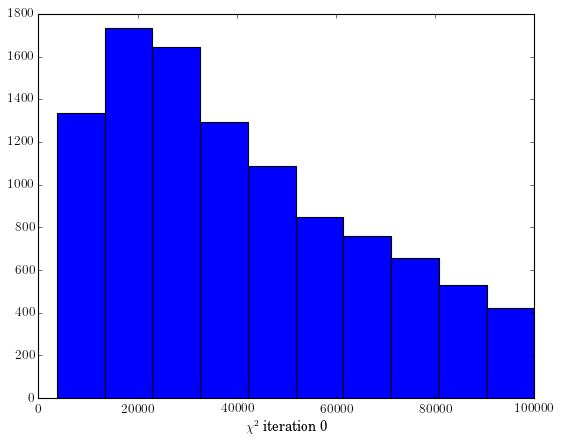

In [5]:
plt.hist(ref['CHI'])
plt.xlabel('$\chi^2$ iteration 0')
plt.show()

In [6]:
wave = ap.rvShift(wl, rv=-80)
ds = dataset.Dataset(wave, tr_ID, tr_flux, tr_ivar, tr_label, tr_ID, tr_flux, tr_ivar)
ds.set_label_names(['T_{eff}', '[Fe/H]'])

In [7]:
md, ds, synth = ap.fitCannonModel(ds)
md.infer_labels(ds)

Done training model. 
Inferring Labels
Inferring Labels


(array([[0.04384457, 0.13061646],
        [0.01756395, 0.03444439],
        [0.03686365, 0.09441655],
        ...,
        [0.01500228, 0.0365218 ],
        [0.01693157, 0.03804625],
        [0.01072191, 0.03431861]]),
 array([6256.29263325, 6177.65523289, 5567.62803761, ..., 6383.90061358,
        6195.48348313, 5440.64452778]))

Diagnostic for label output vs. input
Saved fig 1to1_label_0.png


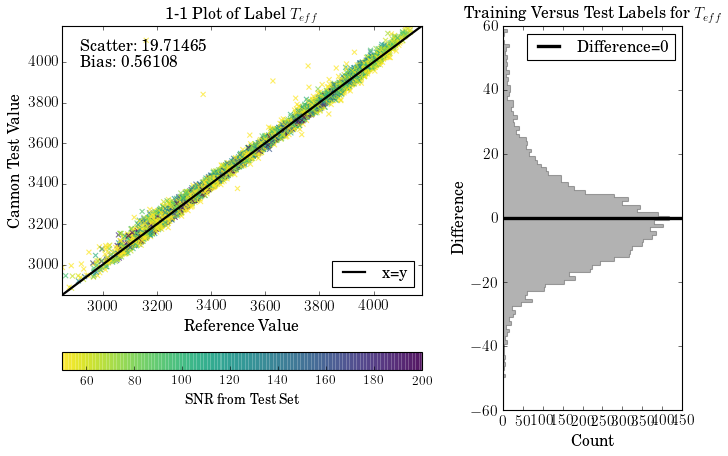

Diagnostic for label output vs. input
Saved fig 1to1_label_1.png


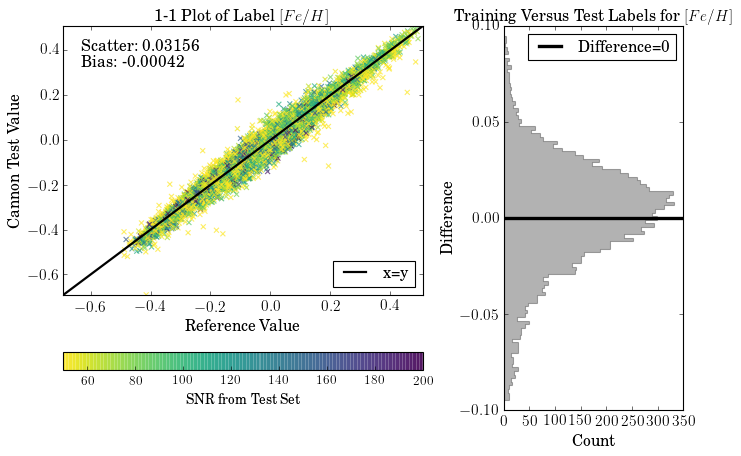

In [8]:
ds.diagnostics_1to1()

In [9]:
chi = chi_sq(ds.tr_flux, synth, ds.tr_ivar)

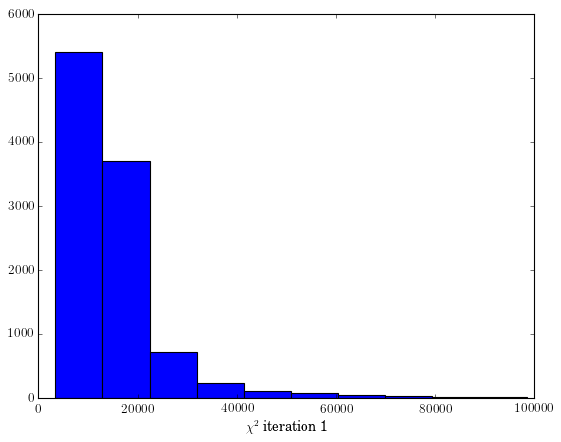

In [10]:
plt.hist(chi)
plt.xlabel('$\chi^2$ iteration 1')
plt.show()

In [11]:
ds2 = dataset.Dataset(wave, tr_ID, tr_flux, tr_ivar, ds.test_label_vals, tr_ID, tr_flux, tr_ivar)
ds2.set_label_names(['T_{eff}', '[Fe/H]'])

In [12]:
md2, ds2, synth2 = ap.fitCannonModel(ds2)
md2.infer_labels(ds2)

Done training model. 
Inferring Labels
Inferring Labels


(array([[0.04392625, 0.11988972],
        [0.01709009, 0.03395429],
        [0.03633565, 0.09097941],
        ...,
        [0.01449538, 0.03486919],
        [0.0167253 , 0.03827938],
        [0.01038146, 0.03248249]]),
 array([6260.27254521, 6230.9691676 , 5578.42829543, ..., 6417.83404671,
        6328.96279524, 5484.65715315]))

Diagnostic for label output vs. input
Saved fig 1to1_label_0.png


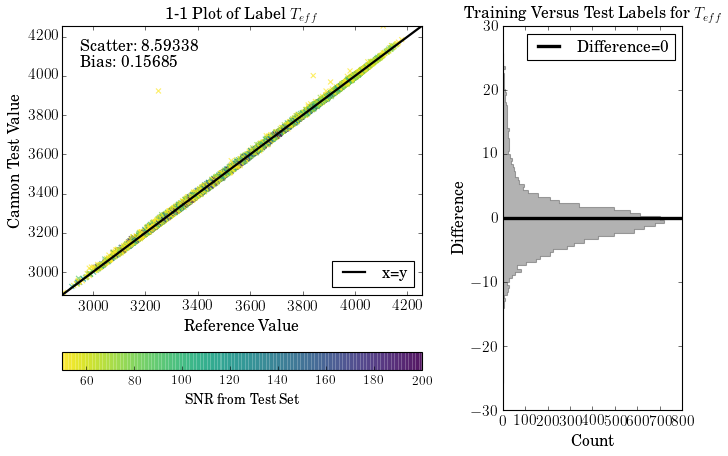

Diagnostic for label output vs. input
Saved fig 1to1_label_1.png


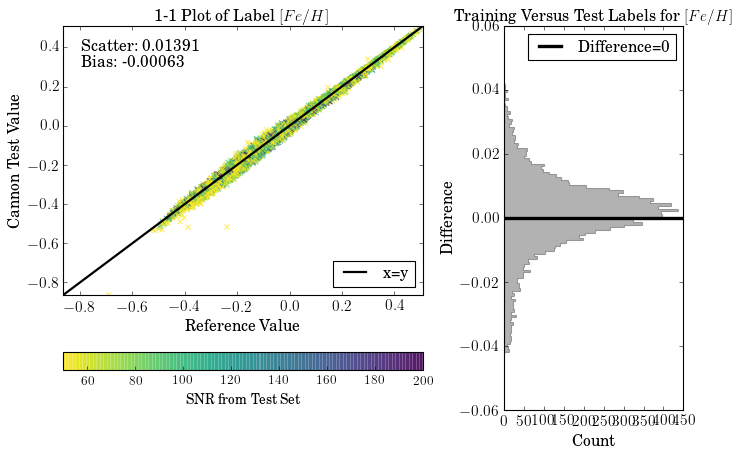

In [12]:
ds2.diagnostics_1to1()

In [13]:
chi2 = chi_sq(ds2.tr_flux, synth2, ds2.tr_ivar)

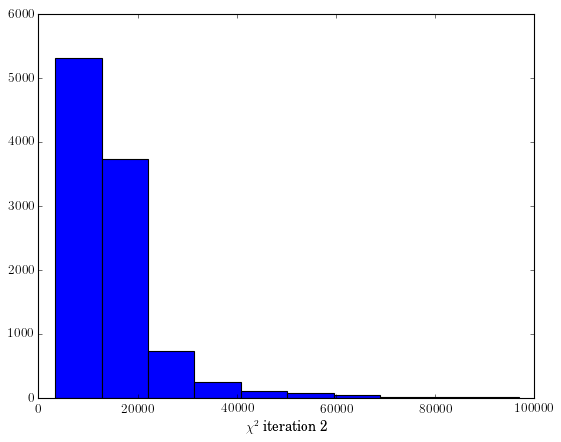

In [14]:
plt.hist(chi2)
plt.xlabel('$\chi^2$ iteration 2')
plt.show()

In [15]:
ds3 = dataset.Dataset(wave, tr_ID, tr_flux, tr_ivar, ds2.test_label_vals, tr_ID, tr_flux, tr_ivar)
ds3.set_label_names(['T_{eff}', '[Fe/H]'])

In [ ]:
md3, ds3, synth3 = ap.fitCannonModel(ds3)
md3.infer_labels(ds3)

In [ ]:
ds3.diagnostics_1to1()

In [ ]:
chi3 = chi_sq(ds3.tr_flux, synth, ds3.tr_ivar)

In [ ]:
plt.hist(chi3)
plt.xlabel('$\chi^2$ iteration 3')
plt.show()

In [19]:
allstar = fits.open('/home/jess/Desktop/Research/data/apogee_data/allStar-l31c.2.fits')
gaia_match = fits.open('/home/jess/Desktop/Research/data/apogee_data/apogee_x_gaiadr2_full_info.fits')

In [29]:
len(allstar[1].data['APOGEE_ID']), len(set(allstar[1].data['APOGEE_ID'])), len(set(gaia_match[1].data['APOGEE_ID_1']))

(277371, 258475, 254478)

In [30]:
miss_ids = list(set(allstar[1].data['APOGEE_ID']) - set(gaia_match[1].data['APOGEE_ID_1']))
len(miss_ids)

3997

In [ ]:
bad_ids = []
dl_dir = '/home/jess/Desktop/Research/data/apogee_data/test_sets/non_gaia'
for ID in miss_ids:
    try:
        ap.download(ID, type='aspcap', dir=dl_dir)
    except:
        bad_ids.append(ID)

Already have file for 2M20315095+4039219
Already have file for 2M03474160+3251437
Already have file for 2M13531316+4406095
Already have file for 2M21502682+3926319
Already have file for 2M18562148+0040344
Already have file for 2M08464981+5741557
Already have file for 2M18452396-0352084
Already have file for 2M19252591+1609480
Already have file for 2M07451901+4207545
Already have file for 2M14400691+5321418
Already have file for 2M18003225-2407292
Already have file for 2M18501218+0101402
Already have file for 2M17513246-2723190
Already have file for 2M14324761+5353046
Already have file for 2M11173203+0013050
Already have file for 2M02361535+0652191
Already have file for 2M05350773-0521014
Already have file for 2M03284323+3110425
['2M00442799+4144103' '2M00442799+4144103'] [4412 4413]
2M00442799+4144103 not found in APOGEE 2.5m survey.
aspcapStar-r8-l31c.2-2M00442799+4144103.fits could not be found in https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/4412/aspcapSta

['2M02470767+0022463'] [2046]
aspcapStar-r8-l31c.2-2M02470767+0022463.fits successfully downloaded. 

['2M18484904+0002204'] [5029]
aspcapStar-r8-l31c.2-2M18484904+0002204.fits successfully downloaded. 

['2M17452940-2854331'] [4330]
aspcapStar-r8-l31c.2-2M17452940-2854331.fits successfully downloaded. 

['2M18554261+0055460'] [5029]
aspcapStar-r8-l31c.2-2M18554261+0055460.fits successfully downloaded. 

['2M05431104+2429510'] [4564]
aspcapStar-r8-l31c.2-2M05431104+2429510.fits successfully downloaded. 

['2M12184333+1340433'] [4490]
aspcapStar-r8-l31c.2-2M12184333+1340433.fits successfully downloaded. 

['2M18192431-1557496'] [4357]
aspcapStar-r8-l31c.2-2M18192431-1557496.fits successfully downloaded. 

['2M17583615-2409271'] [4336]
2M17583615-2409271 not found in APOGEE 2.5m survey.
aspcapStar-r8-l31c.2-2M17583615-2409271.fits could not be found in https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/4336/aspcapStar-r8-l31c.2-2M17583615-2409271.fits or https://dat

2M22152563+0649214 not found in APOGEE 2.5m survey.
aspcapStar-r8-l31c.2-2M22152563+0649214.fits could not be found in https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/1/aspcapStar-r8-l31c.2-2M22152563+0649214.fits or https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/Mdwarfs/aspcapStar-r8-l31c.2-2M22152563+0649214.fits 

['2M05412670-0842245'] [4615]
aspcapStar-r8-l31c.2-2M05412670-0842245.fits successfully downloaded. 

['2M18071082-2013009'] [4338]
2M18071082-2013009 not found in APOGEE 2.5m survey.
aspcapStar-r8-l31c.2-2M18071082-2013009.fits could not be found in https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/4338/aspcapStar-r8-l31c.2-2M18071082-2013009.fits or https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/Mdwarfs/aspcapStar-r8-l31c.2-2M18071082-2013009.fits 

['2M13143702+1746362'] [4128]
aspcapStar-r8-l31c.2-2M13143702+1746362.fits successfully downloaded. 

['2M06070493+1403109'] 

aspcapStar-r8-l31c.2-2M18001036-1910113.fits successfully downloaded. 

['2M21022031-0122308'] [2007]
aspcapStar-r8-l31c.2-2M21022031-0122308.fits successfully downloaded. 

[] []
['2M11353571+0414146'] [4511]
aspcapStar-r8-l31c.2-2M11353571+0414146.fits successfully downloaded. 

['2M17443562-2913057'] [4330]
aspcapStar-r8-l31c.2-2M17443562-2913057.fits successfully downloaded. 

['2M17452298-2852120'] [4330]
aspcapStar-r8-l31c.2-2M17452298-2852120.fits successfully downloaded. 

['2M06360018+0521160'] [4411]
aspcapStar-r8-l31c.2-2M06360018+0521160.fits successfully downloaded. 

['2M17471322-2822321'] [4330]
aspcapStar-r8-l31c.2-2M17471322-2822321.fits successfully downloaded. 

['2M15173540+3240462'] [2370]
aspcapStar-r8-l31c.2-2M15173540+3240462.fits successfully downloaded. 

['2M19182339+1839265'] [4540]
aspcapStar-r8-l31c.2-2M19182339+1839265.fits successfully downloaded. 

['2M05345908-0544303'] [4611]
aspcapStar-r8-l31c.2-2M05345908-0544303.fits successfully downloaded. 

['2M

aspcapStar-r8-l31c.2-2M17442927-2933018.fits successfully downloaded. 

['2M05355535-0547017'] [4611]
aspcapStar-r8-l31c.2-2M05355535-0547017.fits successfully downloaded. 

['2M11053880+4819227'] [4503]
aspcapStar-r8-l31c.2-2M11053880+4819227.fits successfully downloaded. 

['2M18451716-0322321'] [4240]
aspcapStar-r8-l31c.2-2M18451716-0322321.fits successfully downloaded. 

['2M20062180+3558216'] [1]
2M20062180+3558216 not found in APOGEE 2.5m survey.
aspcapStar-r8-l31c.2-2M20062180+3558216.fits could not be found in https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/1/aspcapStar-r8-l31c.2-2M20062180+3558216.fits or https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/Mdwarfs/aspcapStar-r8-l31c.2-2M20062180+3558216.fits 

['2M17454276-2805089'] [4330]
aspcapStar-r8-l31c.2-2M17454276-2805089.fits successfully downloaded. 

['2M04154650+2337341'] [5161]
aspcapStar-r8-l31c.2-2M04154650+2337341.fits successfully downloaded. 

['2M17445025-2919215'

['2M16203801+5235477'] [5184]
aspcapStar-r8-l31c.2-2M16203801+5235477.fits successfully downloaded. 

['2M16274728+2807413'] [2356]
aspcapStar-r8-l31c.2-2M16274728+2807413.fits successfully downloaded. 

['2M17464318-2815388'] [4330]
aspcapStar-r8-l31c.2-2M17464318-2815388.fits successfully downloaded. 

['2M02470057+0744498'] [4479]
aspcapStar-r8-l31c.2-2M02470057+0744498.fits successfully downloaded. 

['2M03290895+3122562'] [4587]
aspcapStar-r8-l31c.2-2M03290895+3122562.fits successfully downloaded. 

['2M19240863+1413412'] [5031]
aspcapStar-r8-l31c.2-2M19240863+1413412.fits successfully downloaded. 

['2M21374471-0145465'] [4260]
2M21374471-0145465 not found in APOGEE 2.5m survey.
aspcapStar-r8-l31c.2-2M21374471-0145465.fits could not be found in https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/4260/aspcapStar-r8-l31c.2-2M21374471-0145465.fits or https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/Mdwarfs/aspcapStar-r8-l31c.2-2M21374471-

['2M18453502-0319582'] [4240]
aspcapStar-r8-l31c.2-2M18453502-0319582.fits successfully downloaded. 

['2M14381530+5044162'] [2225]
aspcapStar-r8-l31c.2-2M14381530+5044162.fits successfully downloaded. 

['2M17154290+3024034'] [2003]
aspcapStar-r8-l31c.2-2M17154290+3024034.fits successfully downloaded. 

['2M09105634+2705519'] [2338]
aspcapStar-r8-l31c.2-2M09105634+2705519.fits successfully downloaded. 

['2M18501362-0143340'] [4240]
aspcapStar-r8-l31c.2-2M18501362-0143340.fits successfully downloaded. 

['2M13464357+2614263'] [4160]
2M13464357+2614263 not found in APOGEE 2.5m survey.
aspcapStar-r8-l31c.2-2M13464357+2614263.fits could not be found in https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/4160/aspcapStar-r8-l31c.2-2M13464357+2614263.fits or https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/Mdwarfs/aspcapStar-r8-l31c.2-2M13464357+2614263.fits 

['2M17551779-2555572'] [4104]
2M17551779-2555572 not found in APOGEE 2.5m survey.
aspca

aspcapStar-r8-l31c.2-2M10463033+1520326.fits successfully downloaded. 

['2M15013124+3739146' '2M15013124+3739146'] [4231 4438]
aspcapStar-r8-l31c.2-2M15013124+3739146.fits successfully downloaded. 

['2M20331678+3959454'] [5037]
aspcapStar-r8-l31c.2-2M20331678+3959454.fits successfully downloaded. 

['2M10264687-0423180'] [1]
2M10264687-0423180 not found in APOGEE 2.5m survey.
aspcapStar-r8-l31c.2-2M10264687-0423180.fits could not be found in https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/1/aspcapStar-r8-l31c.2-2M10264687-0423180.fits or https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/Mdwarfs/aspcapStar-r8-l31c.2-2M10264687-0423180.fits 

['2M18302955-0851359'] [4280]
aspcapStar-r8-l31c.2-2M18302955-0851359.fits successfully downloaded. 

['2M19252879+1417448'] [5031]
aspcapStar-r8-l31c.2-2M19252879+1417448.fits successfully downloaded. 

['2M05402570+2448090'] [4564]
aspcapStar-r8-l31c.2-2M05402570+2448090.fits successfully downloade

['2M17533455-2644569'] [4354]
aspcapStar-r8-l31c.2-2M17533455-2644569.fits successfully downloaded. 

['2M02043481+1249453'] [4478]
aspcapStar-r8-l31c.2-2M02043481+1249453.fits successfully downloaded. 

['2M16252998+3954281' '2M16252998+3954281' '2M16252998+3954281'
 '2M16252998+3954281' '2M16252998+3954281'] [2122 2204 2232 2233 2234]
 '2M16252998+3954281' '2M16252998+3954281'] from dr14 2.5m survey.
aspcapStar-r8-l31c.2-2M16252998+3954281.fits successfully downloaded. 

['2M18450807-0344332'] [4240]
aspcapStar-r8-l31c.2-2M18450807-0344332.fits successfully downloaded. 

['2M18460972-0532029'] [4106]
aspcapStar-r8-l31c.2-2M18460972-0532029.fits successfully downloaded. 

['2M19071549+4506525'] [5007]
aspcapStar-r8-l31c.2-2M19071549+4506525.fits successfully downloaded. 

['2M17465708-2830423'] [4330]
aspcapStar-r8-l31c.2-2M17465708-2830423.fits successfully downloaded. 

['2M01522060+6150364'] [5060]
aspcapStar-r8-l31c.2-2M01522060+6150364.fits successfully downloaded. 

['2M12384771

[] []
['2M18291855-1059532'] [4358]
aspcapStar-r8-l31c.2-2M18291855-1059532.fits successfully downloaded. 

[] []
['2M17470135-2831410'] [4330]
aspcapStar-r8-l31c.2-2M17470135-2831410.fits successfully downloaded. 

['2M17332552-1930292'] [4345]
aspcapStar-r8-l31c.2-2M17332552-1930292.fits successfully downloaded. 

['2M18080102-1820443'] [4356]
aspcapStar-r8-l31c.2-2M18080102-1820443.fits successfully downloaded. 

['2M10272366+1343567'] [5119]
aspcapStar-r8-l31c.2-2M10272366+1343567.fits successfully downloaded. 

['2M17404783-2922545'] [4385]
aspcapStar-r8-l31c.2-2M17404783-2922545.fits successfully downloaded. 

['2M19265799+3741202'] [5021]
aspcapStar-r8-l31c.2-2M19265799+3741202.fits successfully downloaded. 

['2M03273825+3013585'] [4587]
aspcapStar-r8-l31c.2-2M03273825+3013585.fits successfully downloaded. 

['2M18485735-0317170'] [4240]
aspcapStar-r8-l31c.2-2M18485735-0317170.fits successfully downloaded. 

['2M03492570+2456154'] [5171]
aspcapStar-r8-l31c.2-2M03492570+2456154.

['2M17223331+2316389'] [4523]
aspcapStar-r8-l31c.2-2M17223331+2316389.fits successfully downloaded. 

['2M17460452-2832448'] [4330]
aspcapStar-r8-l31c.2-2M17460452-2832448.fits successfully downloaded. 

['2M05463833+0057422'] [5172]
aspcapStar-r8-l31c.2-2M05463833+0057422.fits successfully downloaded. 

['2M17583961-2354420'] [4336]
aspcapStar-r8-l31c.2-2M17583961-2354420.fits successfully downloaded. 

['2M15425854+3039226'] [2372]
aspcapStar-r8-l31c.2-2M15425854+3039226.fits successfully downloaded. 

['2M00465720+1800069'] [4476]
aspcapStar-r8-l31c.2-2M00465720+1800069.fits successfully downloaded. 

['2M18161453-1637136'] [4339]
aspcapStar-r8-l31c.2-2M18161453-1637136.fits successfully downloaded. 

['2M11161656+4613502'] [2325]
aspcapStar-r8-l31c.2-2M11161656+4613502.fits successfully downloaded. 

['2M18031870-2248586'] [4355]
aspcapStar-r8-l31c.2-2M18031870-2248586.fits successfully downloaded. 

['2M17433055-3000124'] [4353]
aspcapStar-r8-l31c.2-2M17433055-3000124.fits success

['2M19215941+4829560'] [5005]
aspcapStar-r8-l31c.2-2M19215941+4829560.fits successfully downloaded. 

[] []
['2M18352610-0627559'] [4280]
aspcapStar-r8-l31c.2-2M18352610-0627559.fits successfully downloaded. 

['2M16282106+3108090'] [2358]
aspcapStar-r8-l31c.2-2M16282106+3108090.fits successfully downloaded. 

['2M21304776+1134074' '2M21304776+1134074'] [4230 4230]
aspcapStar-r8-l31c.2-2M21304776+1134074.fits successfully downloaded. 

['2M18470756-0127313'] [4240]
aspcapStar-r8-l31c.2-2M18470756-0127313.fits successfully downloaded. 

['2M14522409+3737132'] [4231]
aspcapStar-r8-l31c.2-2M14522409+3737132.fits successfully downloaded. 

['2M17460160-2850006'] [4330]
aspcapStar-r8-l31c.2-2M17460160-2850006.fits successfully downloaded. 

['2M19120288+1028080'] [4268]
aspcapStar-r8-l31c.2-2M19120288+1028080.fits successfully downloaded. 

['2M17492005-2751575'] [4354]
aspcapStar-r8-l31c.2-2M17492005-2751575.fits successfully downloaded. 

['2M19143925+1919025'] [4540]
aspcapStar-r8-l31c.2

['2M19254304+1726497'] [4313]
aspcapStar-r8-l31c.2-2M19254304+1726497.fits successfully downloaded. 

['2M06481843+2003295'] [4328]
aspcapStar-r8-l31c.2-2M06481843+2003295.fits successfully downloaded. 

['2M19301049+1654460'] [4313]
aspcapStar-r8-l31c.2-2M19301049+1654460.fits successfully downloaded. 

['2M18423766-0324318'] [4240]
aspcapStar-r8-l31c.2-2M18423766-0324318.fits successfully downloaded. 

['2M17461704-2900058'] [4330]
aspcapStar-r8-l31c.2-2M17461704-2900058.fits successfully downloaded. 

[] []
['2M17503491-2732528'] [4354]
aspcapStar-r8-l31c.2-2M17503491-2732528.fits successfully downloaded. 

['2M09102492+4202476'] [2105]
aspcapStar-r8-l31c.2-2M09102492+4202476.fits successfully downloaded. 

['2M09352735+3553314'] [2179]
aspcapStar-r8-l31c.2-2M09352735+3553314.fits successfully downloaded. 

['2M17262115+5650499' '2M17262115+5650499'] [2034 2257]
aspcapStar-r8-l31c.2-2M17262115+5650499.fits successfully downloaded. 

['2M10464178+1924065'] [4508]
aspcapStar-r8-l31c.2

aspcapStar-r8-l31c.2-2M17544868-2541311.fits successfully downloaded. 

['2M15050341+4105439'] [4497]
aspcapStar-r8-l31c.2-2M15050341+4105439.fits successfully downloaded. 

[] []
['2M18585861+0343092'] [4312]
aspcapStar-r8-l31c.2-2M18585861+0343092.fits successfully downloaded. 

['2M17575749-2358098'] [4336]
aspcapStar-r8-l31c.2-2M17575749-2358098.fits successfully downloaded. 

['2M14234983+4220490'] [2143]
aspcapStar-r8-l31c.2-2M14234983+4220490.fits successfully downloaded. 

['2M10194827+3549038'] [2322]
aspcapStar-r8-l31c.2-2M10194827+3549038.fits successfully downloaded. 

['2M19234704+1531007'] [5031]
aspcapStar-r8-l31c.2-2M19234704+1531007.fits successfully downloaded. 

['2M11330280+0356488'] [4511]
aspcapStar-r8-l31c.2-2M11330280+0356488.fits successfully downloaded. 

['2M18590398+0058493'] [5029]
aspcapStar-r8-l31c.2-2M18590398+0058493.fits successfully downloaded. 

['2M17581358-2356264' '2M17581358-2356264'] [4336 4336]
aspcapStar-r8-l31c.2-2M17581358-2356264.fits succe

['2M03254886+3057258'] [4587]
aspcapStar-r8-l31c.2-2M03254886+3057258.fits successfully downloaded. 

['2M16233849+3036295'] [2358]
aspcapStar-r8-l31c.2-2M16233849+3036295.fits successfully downloaded. 

['2M00524843+4117222'] [5113]
aspcapStar-r8-l31c.2-2M00524843+4117222.fits successfully downloaded. 

['2M18084122-1958435'] [4338]
2M18084122-1958435 not found in APOGEE 2.5m survey.
aspcapStar-r8-l31c.2-2M18084122-1958435.fits could not be found in https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/4338/aspcapStar-r8-l31c.2-2M18084122-1958435.fits or https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/Mdwarfs/aspcapStar-r8-l31c.2-2M18084122-1958435.fits 

['2M05411799-0149292'] [5173]
aspcapStar-r8-l31c.2-2M05411799-0149292.fits successfully downloaded. 

['2M17562048-2520576'] [4104]
2M17562048-2520576 not found in APOGEE 2.5m survey.
aspcapStar-r8-l31c.2-2M17562048-2520576.fits could not be found in https://data.sdss.org/sas/dr14/apogee/sp

['2M14431280+4610227'] [4498]
aspcapStar-r8-l31c.2-2M14431280+4610227.fits successfully downloaded. 

['2M08152504+2839402'] [2321]
aspcapStar-r8-l31c.2-2M08152504+2839402.fits successfully downloaded. 

['2M12183988+1359445'] [4490]
aspcapStar-r8-l31c.2-2M12183988+1359445.fits successfully downloaded. 

['2M14144492+4149274'] [2143]
aspcapStar-r8-l31c.2-2M14144492+4149274.fits successfully downloaded. 

['2M17534906-2555469' '2M17534906-2555469'] [4104 4104]
aspcapStar-r8-l31c.2-2M17534906-2555469.fits successfully downloaded. 

['2M03082560+2619532'] [1]
2M03082560+2619532 not found in APOGEE 2.5m survey.
aspcapStar-r8-l31c.2-2M03082560+2619532.fits could not be found in https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/1/aspcapStar-r8-l31c.2-2M03082560+2619532.fits or https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/Mdwarfs/aspcapStar-r8-l31c.2-2M03082560+2619532.fits 

['2M18430193-0253048'] [4240]
aspcapStar-r8-l31c.2-2M18430193-02530

['2M17430981-2924033'] [4330]
aspcapStar-r8-l31c.2-2M17430981-2924033.fits successfully downloaded. 

['2M10183568+4740007'] [2169]
aspcapStar-r8-l31c.2-2M10183568+4740007.fits successfully downloaded. 

['2M13420283+2827209'] [4160]
aspcapStar-r8-l31c.2-2M13420283+2827209.fits successfully downloaded. 

[] []
['2M17425057-2937543'] [4330]
aspcapStar-r8-l31c.2-2M17425057-2937543.fits successfully downloaded. 

['2M07332760+4130036'] [2075]
aspcapStar-r8-l31c.2-2M07332760+4130036.fits successfully downloaded. 

['2M03504432-0605400'] [2303]
aspcapStar-r8-l31c.2-2M03504432-0605400.fits successfully downloaded. 

['2M01232191+1812336'] [4477]
aspcapStar-r8-l31c.2-2M01232191+1812336.fits successfully downloaded. 

['2M18454124-0151499'] [4240]
aspcapStar-r8-l31c.2-2M18454124-0151499.fits successfully downloaded. 

['2M14523461+4928350'] [2227]
aspcapStar-r8-l31c.2-2M14523461+4928350.fits successfully downloaded. 

['2M19075308+4652061' '2M19075308+4652061'] [4405 5006]
aspcapStar-r8-l31c.2

aspcapStar-r8-l31c.2-2M20324275+4016468.fits successfully downloaded. 

[] []
['2M03513640+2513408'] [5171]
aspcapStar-r8-l31c.2-2M03513640+2513408.fits successfully downloaded. 

[] []
['2M23152202+6131085'] [4317]
aspcapStar-r8-l31c.2-2M23152202+6131085.fits successfully downloaded. 

['2M13405102+1804533'] [4481]
aspcapStar-r8-l31c.2-2M13405102+1804533.fits successfully downloaded. 

['2M17470244-2817450'] [4330]
aspcapStar-r8-l31c.2-2M17470244-2817450.fits successfully downloaded. 

['2M13484385+4238120'] [4233]
aspcapStar-r8-l31c.2-2M13484385+4238120.fits successfully downloaded. 

['2M06150617+4314068'] [5117]
aspcapStar-r8-l31c.2-2M06150617+4314068.fits successfully downloaded. 

['2M16200177+4934355' '2M16200177+4934355'] [2185 2186]
aspcapStar-r8-l31c.2-2M16200177+4934355.fits successfully downloaded. 

[] []
['2M17492799-2756349'] [4354]
aspcapStar-r8-l31c.2-2M17492799-2756349.fits successfully downloaded. 

['2M17594485-2347420'] [4336]
2M17594485-2347420 not found in APOGEE

aspcapStar-r8-l31c.2-2M17545053-2552398.fits could not be found in https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/4104/aspcapStar-r8-l31c.2-2M17545053-2552398.fits or https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/Mdwarfs/aspcapStar-r8-l31c.2-2M17545053-2552398.fits 

['2M11592894+4350311'] [2120]
aspcapStar-r8-l31c.2-2M11592894+4350311.fits successfully downloaded. 

['2M15022242+4145116'] [4497]
aspcapStar-r8-l31c.2-2M15022242+4145116.fits successfully downloaded. 

['2M17525407-2537298'] [4104]
2M17525407-2537298 not found in APOGEE 2.5m survey.
aspcapStar-r8-l31c.2-2M17525407-2537298.fits could not be found in https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/4104/aspcapStar-r8-l31c.2-2M17525407-2537298.fits or https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/Mdwarfs/aspcapStar-r8-l31c.2-2M17525407-2537298.fits 

[] []
['2M11334348+4647477'] [2324]
aspcapStar-r8-l31c.2-2M11334348+4647

['2M10543955+4348002'] [4504]
aspcapStar-r8-l31c.2-2M10543955+4348002.fits successfully downloaded. 

['2M17402723-2941257'] [4385]
aspcapStar-r8-l31c.2-2M17402723-2941257.fits successfully downloaded. 

['2M19272408+1757065'] [4313]
aspcapStar-r8-l31c.2-2M19272408+1757065.fits successfully downloaded. 

['2M17464146-2858256'] [4330]
aspcapStar-r8-l31c.2-2M17464146-2858256.fits successfully downloaded. 

['2M18462206-0153145'] [4240]
aspcapStar-r8-l31c.2-2M18462206-0153145.fits successfully downloaded. 

['2M03443428+3212407'] [4586]
aspcapStar-r8-l31c.2-2M03443428+3212407.fits successfully downloaded. 

['2M18505215+0132595'] [5029]
aspcapStar-r8-l31c.2-2M18505215+0132595.fits successfully downloaded. 

[] []
['2M11072791+4207244' '2M11072791+4207244'] [2111 2168]
aspcapStar-r8-l31c.2-2M11072791+4207244.fits successfully downloaded. 

['2M19433054+2343528'] [4241]
aspcapStar-r8-l31c.2-2M19433054+2343528.fits successfully downloaded. 

['2M15564583+4445163'] [2367]
aspcapStar-r8-l31c.2

aspcapStar-r8-l31c.2-2M05460463+0004581.fits successfully downloaded. 

['2M11452952-1140380'] [4229]
aspcapStar-r8-l31c.2-2M11452952-1140380.fits successfully downloaded. 

['2M12232063+2529441'] [4216]
aspcapStar-r8-l31c.2-2M12232063+2529441.fits successfully downloaded. 

['2M18510426-0312087'] [4240]
aspcapStar-r8-l31c.2-2M18510426-0312087.fits successfully downloaded. 

['2M18202426-1820484'] [4369]
2M18202426-1820484 not found in APOGEE 2.5m survey.
aspcapStar-r8-l31c.2-2M18202426-1820484.fits could not be found in https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/4369/aspcapStar-r8-l31c.2-2M18202426-1820484.fits or https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/Mdwarfs/aspcapStar-r8-l31c.2-2M18202426-1820484.fits 

['2M03463676+3110459'] [4586]
aspcapStar-r8-l31c.2-2M03463676+3110459.fits successfully downloaded. 

['2M18003293-2356433'] [4336]
2M18003293-2356433 not found in APOGEE 2.5m survey.
aspcapStar-r8-l31c.2-2M18003293-235

['2M13562173+2359492'] [4482]
aspcapStar-r8-l31c.2-2M13562173+2359492.fits successfully downloaded. 

['2M05392474+4038437'] [4559]
aspcapStar-r8-l31c.2-2M05392474+4038437.fits successfully downloaded. 

['2M19433790+3225124'] [4542]
aspcapStar-r8-l31c.2-2M19433790+3225124.fits successfully downloaded. 

['2M18004085-2330205'] [4336]
aspcapStar-r8-l31c.2-2M18004085-2330205.fits successfully downloaded. 

['2M18070743-2032575'] [4338]
2M18070743-2032575 not found in APOGEE 2.5m survey.
aspcapStar-r8-l31c.2-2M18070743-2032575.fits could not be found in https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/4338/aspcapStar-r8-l31c.2-2M18070743-2032575.fits or https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/Mdwarfs/aspcapStar-r8-l31c.2-2M18070743-2032575.fits 

['2M09532839+0203263'] [1]
2M09532839+0203263 not found in APOGEE 2.5m survey.
aspcapStar-r8-l31c.2-2M09532839+0203263.fits could not be found in https://data.sdss.org/sas/dr14/apogee/spect

['2M17553457-2520385' '2M17553457-2520385'] [4104 4104]
aspcapStar-r8-l31c.2-2M17553457-2520385.fits successfully downloaded. 

['2M12184389+1306419'] [4490]
aspcapStar-r8-l31c.2-2M12184389+1306419.fits successfully downloaded. 

['2M11045080+1032392'] [4444]
aspcapStar-r8-l31c.2-2M11045080+1032392.fits successfully downloaded. 

['2M15074324+2517565'] [4495]
aspcapStar-r8-l31c.2-2M15074324+2517565.fits successfully downloaded. 

['2M19535976+4017140'] [4466]
aspcapStar-r8-l31c.2-2M19535976+4017140.fits successfully downloaded. 

['2M18110640-1826097'] [4356]
aspcapStar-r8-l31c.2-2M18110640-1826097.fits successfully downloaded. 

['2M20294918+3918042'] [5037]
aspcapStar-r8-l31c.2-2M20294918+3918042.fits successfully downloaded. 

['2M17384075-2245003' '2M17384075-2245003'] [4348 4348]
aspcapStar-r8-l31c.2-2M17384075-2245003.fits successfully downloaded. 

[] []
['2M04204418+4331264'] [4556]
aspcapStar-r8-l31c.2-2M04204418+4331264.fits successfully downloaded. 

['2M18483178-0237430'] [

In [ ]:
len(bad_ids)